# Chapter 15 – Autoencoders - 自编码器

自编码器是能够在**无监督**的情况下学习输入数据的有效表示（叫做**编码**）的人工神经网络（即，训练集是未标记）。
* 这些编码通常具有比输入数据低得多的维度，使得自编码器对降维有用（参见第 8 章）。
* 更重要的是，自编码器可以作为强大的特征检测器，它们可以用于无监督的深度神经网络预训练（正如我们在第 11 章中讨论过的）。
* 最后，他们能够随机生成与训练数据非常相似的新数据；这被称为**生成模型**。例如，你可以在脸部图片上训练自编码器，然后可以生成新脸部。

令人惊讶的是，自编码器只需学习将输入复制到其输出即可工作。 这听起来像是一件小事，但我们会看到以各种方式约束网络可能会让它变得相当困难。例如，你可以限制内部表示的大小，或者可以向输入添加噪声并训练网络以恢复原始输入。这些约束防止自编码器将输入直接复制到输出，这迫使它学习表示数据的有效方法。 简而言之，编码是自编码器在某些限制条件下尝试学习身份函数的副产品。

在本章中，我们将更深入地
* 解释自编码器如何工作，
* 可以施加什么类型的约束
* 以及如何使用 TensorFlow 实现它们，无论是用来降维，特征提取，无监督预训练还是作为生成式模型。

# Setup

In [46]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "15_autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

一对实用程序用于绘制灰度28x28图像：

In [47]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [48]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 1. Efficient Data Representations - 高效的数据表示

你发现以下哪一个数字序列最容易记忆？

* 40, 27, 25, 36, 81, 57, 10, 73, 19, 68
* 50, 25, 76, 38, 19, 58, 29, 88, 44, 22, 11, 34, 17, 52, 26, 13, 40, 20

乍一看，第一个序列似乎应该更容易，因为它要短得多。 但是，如果仔细观察第二个序列，则可能会注意到它遵循两条简单规则：**偶数是前面数的一半，奇数是前面数的三倍加一（**这是一个着名的序列，称为冰雹序列）。

一旦你注意到这种模式，第二个序列比第一个更容易记忆，因为你只需要记住两个规则，第一个数字和序列的长度。 请注意，如果你可以快速轻松地记住非常长的序列，则你不会在意第二个序列中存在的模式。 你只需要了解每一个数字，就是这样。 事实上，很难记住长序列，因此**识别模式**非常有用，并且希望能够澄清为什么在训练过程中限制自编码器会促使它发现并利用数据中的模式。


记忆，感知和模式匹配之间的关系在 20 世纪 70 年代早期由 William Chase 和 Herbert Simon 进行过着名的研究。 他们观察到，专家棋手能够通过观看棋盘5秒钟来记忆所有棋子的位置，这是大多数人认为不可能完成的任务。 然而，只有当这些棋子被放置在现实位置（来自实际比赛）时才是这种情况，而不是随机放置棋子。 国际象棋专家没有比你更好的记忆，他们只是更容易看到国际象棋模式，这要归功于他们对比赛的经验。 注意模式有助于他们有效地存储信息。

就像这个记忆实验中的象棋棋手一样，一个自编码器会查看输入信息，将它们转换为高效的内部表示形式，然后吐出一些（希望）看起来非常接近输入的东西。 自编码器总是由两部分组成：
* 将输入转换为内部表示的编码器（或识别网络），
* 然后是将内部表示转换为输出的解码器（或生成网络）（见图 15-1）。

如你所见，自编码器通常具有与**多层感知器**（MLP，请参阅第 10 章）相同的体系结构，**但输出层中的神经元数量必须等于输入数量**。 在这个例子中，只有一个由两个神经元（编码器）组成的隐藏层和一个由三个神经元（解码器）组成的输出层。 由于自编码器试图重构输入，所以输出通常被称为**重建**，并且损失函数包含**重建损失**，当重建与输入不同时，重建损失会对模型进行惩罚

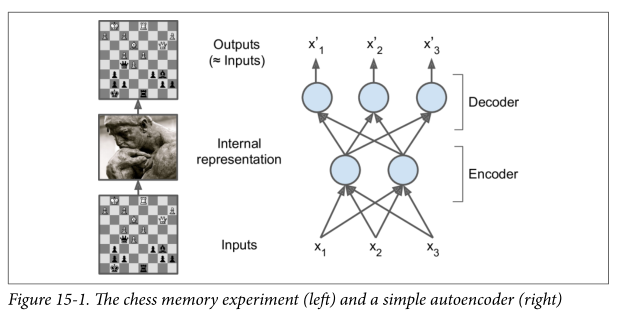

由于内部表示具有比输入数据更低的维度（它是 2D 而不是 3D），所以自编码器被认为是**不完整的**。 不完整的自编码器不能简单地将其输入复制到编码，但它必须找到一种方法来输出其输入的副本。 它被迫学习输入数据中最重要的特征（并删除不重要的特征）。

我们来看看如何实现一个非常简单的不完整的自编码器，以降低维度。

# 2. Performing PCA with an Undercomplete Linear Autoencoder - 使用欠完全线性自动编码器执行PCA 

构建3D数据集：

In [49]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

规范化数据：

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

现在让我们构建Autoencoder

如果自动编码器仅使用线性激活，则成本函数为均方误差（MSE），然后可以证明它最终执行**主成分分析**（见第8章）。

以下代码构建一个简单的线性自动编码器,在3D数据集上执行PCA，将其投影到2D：

注意：我们现在使用`tf.layers模块中的dense（）`函数，而不是使用`tensorflow.contrib.layers`模块中的`fully_connected（）`函数，该函数在编写本章时不存在。这是首选，因为`contrib`中的任何内容都可能更改或删除，恕不另行通知，而`tf.layers`是官方API的一部分。正如你将看到的，代码大致相同。

与本章相关的主要差异是：

* `scope` 参数已重命名为 `name`, 在具有该参数的所有参数中删除了`_fn`后缀 (例如， `activation_fn` 参数已重命名为`activation`).
* `weights`参数重命名为 `kernel` ,权重变量现在命名为 `"kernel"` 而不是 `"weights"`,
* the bias variable 现在被命名为`"bias"` 而不是 `"biases"`,
* 默认 activation is `None` 而不是 `tf.nn.relu`

In [51]:
import tensorflow as tf

reset_graph()

n_inputs = 3 # 3D输入
n_hidden = 2  # 二维编码
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

这段代码与我们在过去章节中构建的所有MLP实际上没有太大差别。需要注意的两件事是：
* 输出数等于输入数。
* 为了执行简单的PCA，我们设置`activation_fn = None`（即，所有神经元都是线性的），并且成本函数是`MSE`。 我们很快就会看到更复杂的自动编码器。

现在让我们加载数据集，在训练集上训练模型，并用它来编码测试集（即将其投影到2D）：

In [52]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  

n_iterations = 1000
codings = hidden # 隐藏层的输出提供编码

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train}) # no labels（无监督）
    codings_val = codings.eval(feed_dict={X: X_test})

如果出现以下类似错误：

`Blas GEMM launch failed : a.shape=(100, 3), b.shape=(3, 2), m=100, n=2, k=3`

这是调用GPU时，显存分配遇到了问题，比较保险的方式是在模型训练之前为tensorflow或者keras分配显存空间。[解决办法:](https://www.jianshu.com/p/72c4403253aa)tensorflow就用如下语句创建session：
```python
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  
```


Saving figure linear_autoencoder_pca_plot


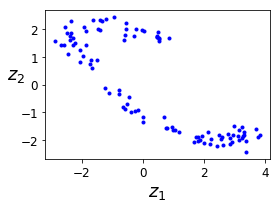

In [53]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

图15-2显示了原始3D数据集（在左侧）和自动编码器的隐藏层（即右侧的编码层）的输出。正如你所看到的，自动编码器找到了最好的2D平面来投影数据，保留尽可能多的数据方差（就像PCA一样）

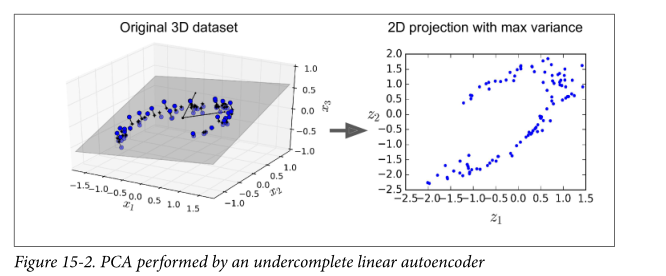

# 3. Stacked Autoencoders

就像我们讨论的其他神经网络一样，自动编码器可以有多个隐藏层。在这种情况下，它们被称为**堆叠自动编码器**（或深度自动编码器）。添加更多层有助于自动编码器学习更复杂的编码。但是，必须注意不要使自动编码器太强大。

想象一个编码器如此强大，它只是学会将每个输入映射到一个任意数字（并且解码器学习反向映射）。显然，这样的自动编码器将完美地重建训练数据，但是它不会在过程中学习任何有用的数据表示（并且它不可能很好地适用于新实例）。

堆叠自动编码器的架构通常是**关于中央隐藏层（编码层）对称**的。简单来说，它看起来像一个三明治。例如，MNIST的自动编码器（在第3章中介绍）可能有784个输入，其次是隐藏层有300个神经元，然后是150个神经元的中央隐藏层，然后是另一个隐藏层有300个神经元，输出层有784个神经元。该堆叠自动编码器如图15-3所示。

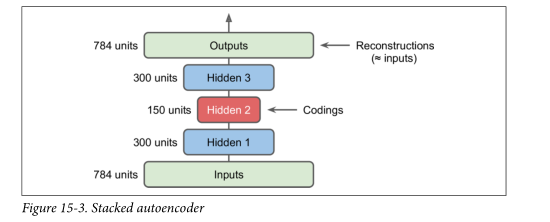

## 3.1  TensorFlow Implementation - TensorFlow 实现

你可以实现堆叠自动编码器，就像常规深度MLP一样。特别是，我们可以应用第11章中用于训练深度网络的相同技术。 例如，以下代码
* 为MNIST构建堆叠自动编码器，
* 使用He初始化，
* ELU激活函数
* $ ℓ2 $正则化。

代码应该看起来非常熟悉，除了没有标签（没有y）：

下载数据：

In [54]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


**Train all layers at once**

让我们构建一个堆叠的自动编码器，
* 它有**3个隐藏层和1个输出层**（即2个堆叠的自动编码器）。 
* 我们将使用ELU激活，He初始化和L2正则化。

注意：由于`tf.layers.dense（）`函数与`tf.contrib.layers.arg_scope（）`（本书中使用的）不兼容，我们现在使用python的`functools.partial（）`函数。

它可以很容易地创建一个`my_dense_layer（）`函数，该函数只调用自动设置所需参数的`tf.layers.dense（）`（除非在调用`my_dense_layer（）`时覆盖它们）。

In [55]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 编码
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He 初始化

# 等价于: he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

现在让我们训练吧！ 请注意，我们不提供目标值（不使用`y_batch`）。 这是无监督的训练。

In [56]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

09% Train MSE: 0.023920039
19% Train MSE: 0.011482951
29% Train MSE: 0.0102210175
3 Train MSE: 0.009902515
49% Train MSE: 0.010373088


此函数加载模型，在测试集上对其进行评估（它测量重建误差），然后显示原始图像及其重建：

In [57]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
Saving figure reconstruction_plot


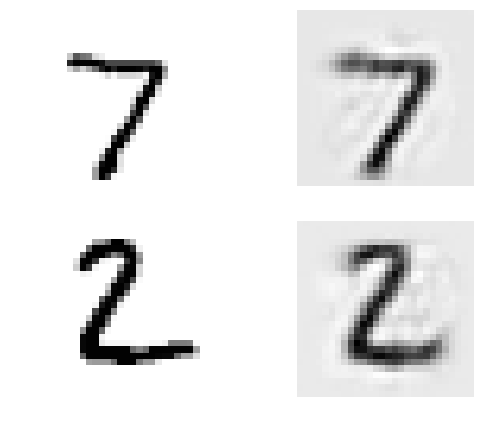

In [58]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

## 3.2 Tying weights

当自动编码器整齐对称时，就像我们刚刚建立的那样，常用技术是将解码器层的权重与编码器层的权重联系起来。这样可以减少模型中的权重数量，加快训练速度并限制过拟合的风险。

具体来说，如果自动编码器总共有 $N$ 层（不计入输入层），则 $W_L$表示第 $L$ 层的连接权重（例如，第1层是第一个隐藏层，第 $\frac{N}{2}$层是编码层，第 $N$ 层是输出层），那么解码器层权重可以简单地定义为：$ W_{N-L+1} = W_L^T$
$（L = 1,2，...，N2）$。

不幸的是，使用`fully_connected（）`函数在TensorFlow中实现绑定权重有点麻烦;实际上，手动定义网络层实际上更容易。 结果是代码明显更加冗长：

通常将编码器和解码器的权重联系起来（`weights_decoder = tf.transpose（weights_encoder）`）。

不幸的是，这使得使用`tf.layers.dense（）`函数变得不可能（或非常棘手），因此我们需要手动构建Autoencoder：

In [59]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 编码
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [60]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

这段代码非常简单，但有几点需要注意：

* 第一，`weight3`和`weights4`不是变量，它们分别是权重2和权重1的转置（它们与它们“联系”）。

* 其次，由于它们不是变量，因此将它们正规化是没有用的：我们只调整`weight1`和`weights2`。

* 第三，偏见永远不会被束缚，也永远不会正规化。

In [61]:
saver = tf.train.Saver()

In [62]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

09% Train MSE: 0.01506695
1 Train MSE: 0.016488748
2 Train MSE: 0.017375939
3 Train MSE: 0.016878333
49% Train MSE: 0.015587721


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


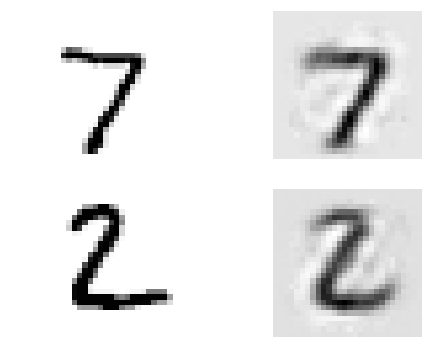

In [63]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

## 3.3 Training One Autoencoder at a Time - 一次训练一个自动编码器

一次训练一个浅的自动编码器通常要快得多，而不是像我们刚才那样一次性训练整个堆叠自动编码器；然后将它们全部堆叠成一个堆叠的自动编码器（因此得名），如图15-4所示。 这对于非常深的自动编码器尤其有用。

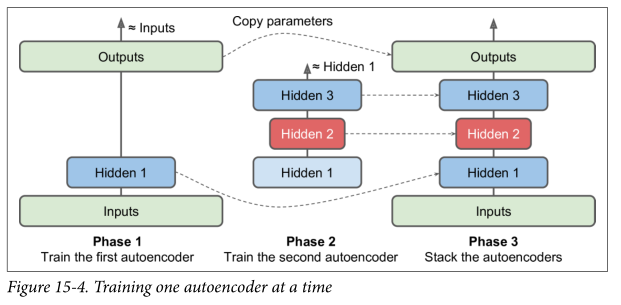

* 在训练的第一阶段期间，第一自动编码器学习重建输入。
* 在第二阶段期间，第二自动编码器学习重建第一自动编码器的隐藏层的输出。

* 最后，你只需使用所有这些自动编码器构建一个大三明治，如图15-4所示（即，你首先堆叠每个自动编码器的隐藏层，然后以相反的顺序堆叠输出层）。

这为你提供了最终的堆叠自动编码器。你可以通过这种方式轻松训练更多自动编码器，构建一个非常深的堆叠自动编码器。

要实现这种多相训练算法，

* **最简单的方法是为每个阶段使用不同的TensorFlow图**。训练自动编码器后，你只需通过它运行训练集并捕获隐藏层的输出。然后，该输出用作下一个自动编码器的训练集。一旦所有自动编码器都经过这种方式的训练，你只需复制每个自动编码器的权重和偏差，并使用它们构建堆叠自动编码器。实现这种方法非常简单，所以我们不会在这里详细说明，但请查看Jupyter笔记本中的代码作为示例。


* **另一种方法是使用包含整个堆叠自动编码器的单个图形**，加上一些额外的操作来执行每个训练阶段，如图15-5所示。

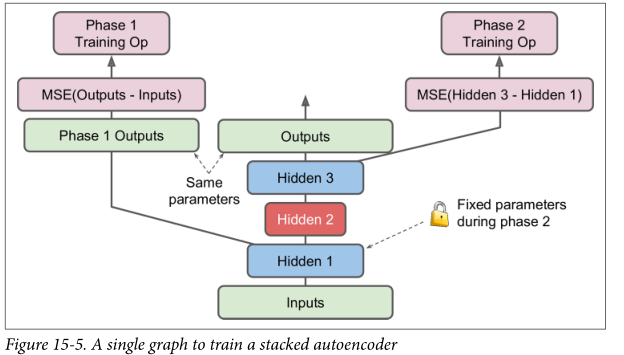

这值得一点解释：

* 图中的中心列是全堆叠自动编码器。这部分可以在训练后使用。

* 左列是运行第一阶段培训所需的一组操作。它创建一个绕过隐藏层2和3的输出层。此输出层与堆叠自动编码器的输出层共享相同的权重和偏差。最重要的是训练操作，**旨在使输出尽可能接近输入**。因此，该阶段将训练隐藏层1和输出层（即第一自动编码器）的权重和偏差。

* 图中的右列是运行第二阶段训练所需的一组操作。它增加了训练操作，**旨在使隐藏层3的输出尽可能接近隐藏层的输出**。请注意，我们必须在运行阶段2时冻结隐藏的第1层。该阶段将训练隐藏层2和3（即第二自动编码器）的权重和偏差。

###  3.3.1  Training one Autoencoder at a time in multiple graphs - 在多个图形中一次训练一个Autoencoder

有很多方法可以一次训练一个Autoencoder。

* **第一种方法**是使用不同的图表训练每个Autoencoder

* 然后我们通过简单地使用从这些自动编码器复制的权重和偏差来初始化它来创建Stacked Autoencoder。


让我们创建一个函数，该函数将训练一个自动编码器并返回变换后的训练集（即隐藏层的输出）和模型参数。

In [64]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

现在让我们训练两个Autoencoders。

* 第一个是训练数据训练，
* 第二个是训练前一个Autoencoder的隐藏层输出：

In [65]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

09% Train MSE: 0.01851794
1 Train MSE: 0.01868272
2 Train MSE: 0.018467719
3 Train MSE: 0.019231759
0 Train MSE: 0.0042360835
19% Train MSE: 0.004832601
2 Train MSE: 0.0046686814
3 Train MSE: 0.0044038515


最后，我们可以**通过简单地重用我们刚刚训练过的Autoencoders的权重和偏差来创建Stacked Autoencoder**：

In [66]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

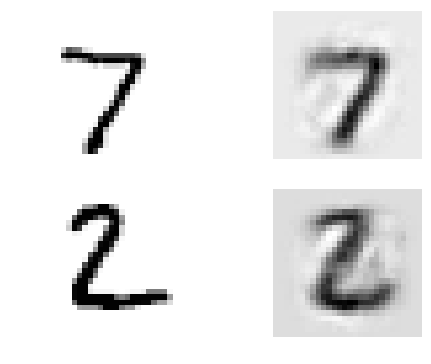

In [67]:
show_reconstructed_digits(X, outputs)

### 3.3.2  Training one Autoencoder at a time in a single graph - 在一个图表中一次训练一个Autoencoder

**另一种方法**是使用单个图。为此，我们为完整的Stacked Autoencoder创建了图形，但是我们还添加了操作来独立训练每个Autoencoder：

* **阶段1** 训练底层和顶层（即第一自动编码器），
* **阶段2** 训练两个中间层（即第二自动编码器）。

In [68]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [69]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

* 第一阶段相当简单：我们只创建一个跳过隐藏层2和3的输出层，然后构建训练操作以最小化输出和输入之间的距离（加上一些正则化）。


* 第二阶段只是添加最小化隐藏层 3 的输出与隐藏层 1 之间的距离所需的操作（也具有一些正则化）。最重要的是，我们为`minim（）`方法提供了可训练变量列表，确保省去`weight1和biases1`;这有效地在阶段2期间冻结隐藏的第1层。

* 在执行阶段，所有你需要做的就是为一些epochs运行第一阶段的训练操作，然后在第二阶段训练操作一些更多的epochs。


由于隐藏层1在阶段2期间被冻结，因此对于任何给定的训练实例，其输出将始终相同。为了避免在每个时期重新计算隐藏层1的输出，你可以
* 在阶段1结束时为整个训练集计算它，
* 然后在阶段2期间直接提供隐藏层1的缓存输出。

这可以为你带来不错的性能提升。

In [70]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [71]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.007406866
1 Train MSE: 0.0078288205
2 Train MSE: 0.007728097
3 Train MSE: 0.0074090064
Training phase #2
09% Train MSE: 0.35758996
1 Train MSE: 0.00593613
2 Train MSE: 0.0030089526
3 Train MSE: 0.0024365915
Test MSE: 0.009815397


###  3.3.3  Cache the frozen layer outputs

In [72]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.0075382586
1 Train MSE: 0.007754701
2 Train MSE: 0.007343679
39% Train MSE: 0.007837775
Training phase #2
0 Train MSE: 0.18597357
1 Train MSE: 0.0044647465
2 Train MSE: 0.002462252
3 Train MSE: 0.0020415403
Test MSE: 0.009790834


## 3.4  Visualizing the Reconstructions - 可视化重建


**确保自动编码器经过适当训练的一种方法是比较输入和输出**。它们必须非常相似，差异应该是不重要的细节。 让我们绘制两个随机数字及其重建：

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


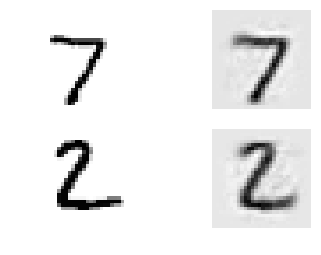

In [73]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

看起来足够接近。所以自动编码器已经正确地学会了重现它的输入，但是它学到了有用的特征吗？让我们来看看。


## 3.5  Visualizing the extracted features - 可视化特征


一旦你的自动编码器学学到了一些特征，你可能想看看他们。有各种各样的技术。可以说最简单的技术是考虑每个隐藏层中的每个神经元，并找到最能激活它的训练实例。


* 这对于顶层隐藏层特别有用，因为它们通常捕获相对较大的特征，你可以轻松地在包含它们的一组训练实例中发现这些特征。例如，如果神经元在看到图片中的猫时强烈激活，那么激活它的图片最明显都包含猫。

* 然而，对于较低层，这种技术不能很好地工作，因为这些特征更小，更抽象，因此通常很难准确理解神经元所兴奋的东西。


让我们看看另一种技术。对于第一个隐藏层中的每个神经元，你可以创建一个图像，其中像素的强度对应于与给定神经元的连接的权重。例如，以下代码绘制了第一个隐藏层中五个神经元所学习的特征：

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt
Saving figure extracted_features_plot


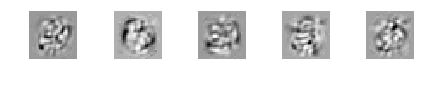

In [74]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("extracted_features_plot") # not shown
plt.show()                          # not shown

前四个特征似乎对应于小补丁，而第五个特征似乎寻找垂直笔画（请注意，这些功能来自堆叠的去噪自动编码器，我们将在后面讨论）。


另一种技术是为自动编码器提供随机输入图像，测量激活你感兴趣的神经元，然后执行反向传播以调整图像，使神经元更加激活。如果你多次迭代（执行渐变上升），图像将逐渐变成最令人兴奋的图像（对于神经元）。这是一种有用的技术，可视化神经元正在寻找的输入类型。

最后，如果你使用自动编码器执行无监督预训练——例如，对于分类任务——**验证自动编码器学习的特征有用的一种简单方法是测量分类器的性能**。

# 4.  Unsupervised pretraining - 使用堆叠自动编码器进行无监督预训练


正如我们在第11章中讨论过的，

* 如果你正在处理复杂的监督任务，但是你没有大量标记的训练数据，那么一种解决方案是找到执行类似任务的神经网络，然后重用其较低层。这使得仅使用很少的训练数据训练高性能模型成为可能，因为你的神经网络不必学习所有低级特征;它只会重用现有网络学到的特征探测器。


* 同样，如果你有一个大型数据集，但大部分都是未标记的，你可以首先使用所有数据训练堆叠自动编码器，然后重复使用较低层为你的实际任务创建神经网络，并使用标记数据对其进行训练。例如，图15-8显示了如何使用堆叠自动编码器执行无监督预训练分类神经网络。

如前所述，堆叠自动编码器本身通常一次训练一个自动编码器。在训练分类器时，如果你确实没有太多标记的训练数据，则可能需要冻结预训练的层（至少是较低的层）。

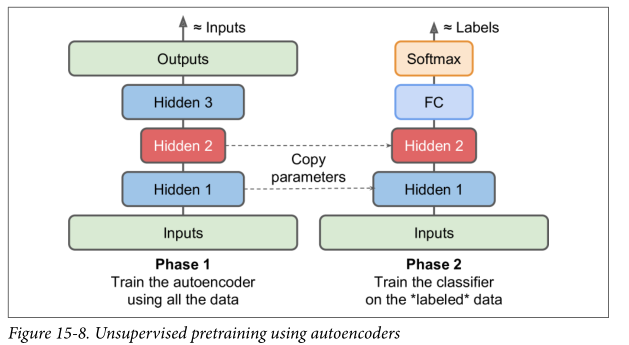

这种情况实际上很常见，因为构建一个大的未标记数据集通常很便宜（例如，一个简单的脚本可以从互联网上下载数百万个图像），但标记它们只能由人类可靠地完成（例如，将图像分类为可爱或不）。标记实例是耗时且昂贵的，因此仅具有几千个标记实例是很常见的。


正如我们之前讨论的，当前深度学习海啸的一个触发因素是Geoffrey Hinton等人在2006年的发现。深度神经网络可以以无监督的方式预先训练。他们使用受限制的玻尔兹曼机器（见附录E），但在2007年Yoshua Bengio等人表明自动编码器工作得很好。


TensorFlow实现没有什么特别之处：只需使用所有训练数据训练自动编码器，然后重复使用其编码器层来创建新的神经网络（有关如何重用预训练层的更多详细信息，请参阅第11章，或查看Jupyter笔记本中的代码示例）。


到目前为止，为了使自动编码器学习有趣的特征，我们限制了编码层的大小，使其不完整。实际上还有许多其他类型的约束可以使用，包括允许编码层与输入一样大，或者甚至更大，从而导致过度完整的自动编码器。我们现在来看看其中的一些方法。

让我们为MNIST分类创建一个小型神经网络：


In [75]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

普通训练（无预训练）：


In [76]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.97333336 Test accuracy: 0.9334
1 Train accuracy: 0.98 Test accuracy: 0.936
2 Train accuracy: 0.97333336 Test accuracy: 0.9382
39% Train accuracy: 0.9866667 Test accuracy: 0.9489


现在重用我们预先训练的自动编码器的前两层：

In [77]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
09% Train accuracy: 0.9533333	Test accuracy: 0.9294
1 Train accuracy: 0.96666664	Test accuracy: 0.9342
2 Train accuracy: 0.98	Test accuracy: 0.9449
3 Train accuracy: 0.9866667	Test accuracy: 0.9462


# 5.  Stacked denoising Autoencoder - 堆叠去噪自动编码器

**强制自动编码器学习有用特征的另一种方法是向其添加噪声输入**，训练它以恢复原始的无噪声输入。这可以防止自动编码器将其输入简单地复制到其输出，因此最终必须在数据中找到模式。

自20世纪80年代以来，使用自动编码器去除噪声的想法一直存在（例如，在Yann LeCun 1987年的硕士论文中提到过）。

* 在2008年的一篇论文中，Pascal Vincent等人表明自动编码器也可用于特征提取。

* 在2010年的一篇论文中，Vincent等人介绍了**堆叠去噪自动编码器**。
  * 噪声可以是添加到输入端的纯高斯噪声，
  * 或者它可以随机关闭输入，就像在丢失中一样（在第11章中介绍）。
  
  图15-9显示了这两个选项。

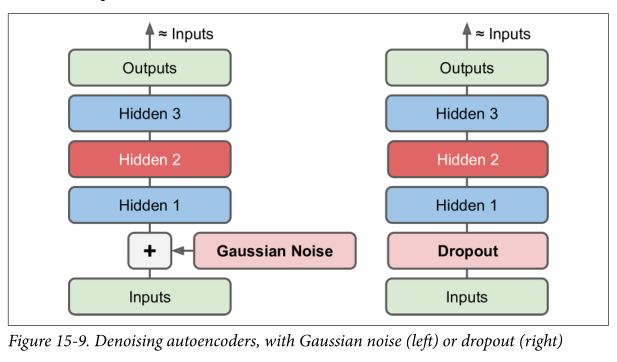

## 5.1 TensorFlow Implementation  - TensorFlow 实现

在TensorFlow中实现去噪自动编码器并不太难。让我们从高斯噪声开始。 它实际上就像训练常规自动编码器一样，除了你为输入添加噪声，并且重建损失是根据原始输入计算的：

注意：本书使用`tf.contrib.layers.dropout（）`而不是`tf.layers.dropout（）`（本章编写时不存在）。现在最好使用`tf.layers.dropout（）`，因为contrib模块中的任何内容都可能更改或删除，恕不另行通知。`tf.layers.dropout（）`函数几乎与`tf.contrib.layers.dropout（）`函数相同，除了一些细微差别。

最重要的是：
  
* 你必须指定the dropout rate (`rate`)而不是保持概率-the keep probability (`keep_prob`),其中 `rate`等于`1 - keep_prob`,
* `is_training` 参数重命名为 `training`.

使用高斯噪声

In [78]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [79]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

由于`X`的形状仅在**构建阶段**被部分定义，我们事先无法知道必须添加到`X`的噪音的形状。

* 我们不能调用`X.get_shape（`），因为这只会返回部分定义的`X`形状（[None，n_inputs]），而`random_normal（）`需要完全定义的形状，因此它会引发异常。 

* 相反，我们调用`tf.shape（X）`，它创建一个在运行时将返回`X`形状的操作，该操作将在该点完全定义。

In [80]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [81]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.044004317
1 Train MSE: 0.042995136
2 Train MSE: 0.041826446
3 Train MSE: 0.04103372
4 Train MSE: 0.040177725
5 Train MSE: 0.038485397
6 Train MSE: 0.039761316
7 Train MSE: 0.04209128
8 Train MSE: 0.039764088
9 Train MSE: 0.040295053


使用dropout

In [82]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [83]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [84]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

在**训练期间**我们必须使用`feed_dict`将`training`设置为`True`（如第11章所述）：
```python
sess.run(training_op, feed_dict={X: X_batch, is_training: True})
```

然而，在**测试期间**，没有必要将`training`设置为`False`，因为我们在调用`placeholder_with_default（）`函数时将其设置为默认值。


In [85]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

09% Train MSE: 0.02959963
1 Train MSE: 0.029670006
29% Train MSE: 0.026523616
3 Train MSE: 0.026781008
4 Train MSE: 0.026440252
59% Train MSE: 0.026834942
6 Train MSE: 0.026351236
7 Train MSE: 0.027300986
8 Train MSE: 0.026488299
9 Train MSE: 0.02635668


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


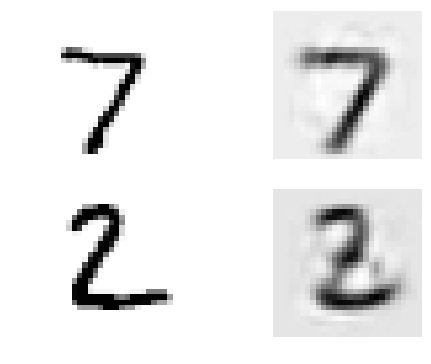

In [86]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

# 6.  Sparse Autoencoder - 稀疏自动编码器

**另一种通常会导致良好特征提取的约束是稀疏性**：通过向成本函数添加适当的项，推动自动编码器以减少编码层中的活动神经元的数量。例如，可以推动它在编码层中平均仅具有5％的显着活跃的神经元。这迫使自动编码器将每个输入表示为少量激活的组合。因此，编码层中的每个神经元通常最终代表一个有用的特征（如果你每个月只说几个字，你可能会试着让它们值得一听）。


为了支持稀疏模型，我们必须

* 首先在每次训练迭代时测量编码层的实际稀疏度。我们通过计算整个训练批次中编码层中每个神经元的平均激活来实现。批量大小不能太小，否则平均值不准确。

* 一旦我们对每个神经元进行平均激活，我们想**通过在成本函数中添加稀疏性损失来惩罚过于活跃的神经元**。例如，如果我们测量神经元的平均激活为0.3，但目标稀疏度为0.1，则必须惩罚它以激活更少。

   * 一种方法可以简单地将平方误差 $(0.3-0.1)^2$ 加到成本函数中，但实际上更好的方法是使用`Kullback-Leibler`散度（在第4章中简要讨论），它具有比均方误差更强的梯度，如图15-10所示。

Saving figure sparsity_loss_plot


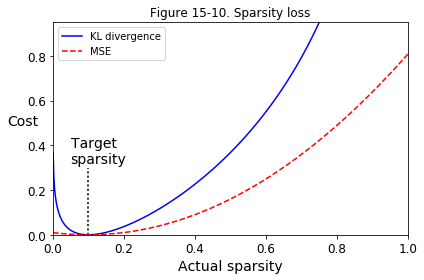

In [87]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

plt.title('Figure 15-10. Sparsity loss')
save_fig("sparsity_loss_plot")

给定两个离散概率分布 $P$ 和 $Q$，$KL$之间的差异,注意到$D_{KL}（P∥Q）$，可以使用公式15-1计算这些分布。

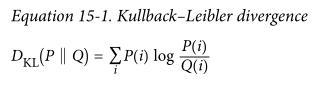

在我们的例子中，我们想要测量编码层中的神经元将激活的目标概率 $p$ 与实际概率 $q$ 之间的偏差（即，训练批次的平均激活）。因此，KL 差异简化为公式15-2。
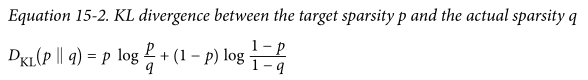

一旦我们计算了编码层中每个神经元的稀疏度损失，我们只是累加这些损失，并将结果添加到成本函数中。为了控制稀疏性损失和重建损失的相对重要性，我们可以将稀疏性损失乘以稀疏度权重超参数。

* 如果此权重太高，模型将紧贴目标稀疏度，但它可能无法正确重建输入，使模型无用。
* 相反，如果它太低，模型将主要忽略稀疏性目标，它不会学习任何有趣的特征。

## 6.1  TensorFlow Implementation - TensorFlow 实现

In [88]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings - 稀疏编码
n_outputs = n_inputs

In [89]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [90]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

08% Train MSE: 0.13483515 	Sparsity loss: 0.42173785 	Total loss: 0.21918273
1 Train MSE: 0.058796614 	Sparsity loss: 0.010896608 	Total loss: 0.060975935
2 Train MSE: 0.053752076 	Sparsity loss: 0.020105548 	Total loss: 0.057773184
3 Train MSE: 0.047628514 	Sparsity loss: 0.039966185 	Total loss: 0.05562175
4 Train MSE: 0.044760786 	Sparsity loss: 0.011620072 	Total loss: 0.0470848
5 Train MSE: 0.04037644 	Sparsity loss: 0.09304121 	Total loss: 0.058984682
68% Train MSE: 0.03884226 	Sparsity loss: 0.04629005 	Total loss: 0.04810027
7 Train MSE: 0.03782742 	Sparsity loss: 0.07588796 	Total loss: 0.053005014
8 Train MSE: 0.033216964 	Sparsity loss: 0.020068452 	Total loss: 0.037230656
9 Train MSE: 0.031438425 	Sparsity loss: 0.0965075 	Total loss: 0.050739925
10 Train MSE: 0.027383836 	Sparsity loss: 0.0670876 	Total loss: 0.040801354
11% Train MSE: 0.024683421 	Sparsity loss: 0.09008203 	Total loss: 0.04269983
12 Train MSE: 0.02333605 	Sparsity loss: 0.05774161 	Total loss: 0.03488437


INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


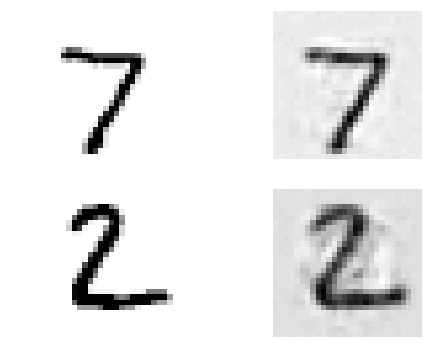

In [92]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

请注意，编码层必须输出0到1的值，这就是我们使用sigmoid激活函数的原因：

In [93]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)


一个简单的技巧可以加速收敛：

我们可以**选择具有更大梯度的重建损失，而不是使用MSE**。 交叉熵通常是一个不错的选择。要使用它，我们必须对输入进行标准化，使它们采用从0到1的值，并**在输出层中使用逻辑激活函数**，这样输出也会采用0到1之间的值。

TensorFlow的`sigmoid_cross_entropy_with_logits（）`函数负责将`logistic（sigmoid）`激活函数有效地应用于输出并计算交叉熵：

In [94]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

请注意，训练期间不需要输出操作（我们只在想要查看重建时使用它）。

# 7. Variational Autoencoder - 变分自动编码器

另一个重要的自动编码器类别是由Diederik Kingma和Max Welling在2014年推出的，并迅速成为最受欢迎的自动编码器类型之一：**变分自动编码器**。它们与我们到目前为止讨论的所有自动编码器完全不同，

特别是：

* 它们是**概率自动编码器**，意味着即使在训练之后，它们的输出也部分地由机会确定（与仅在训练期间使用随机性的自动编码器去噪相反）。

* 最重要的是，它们是**生成自动编码器**，这意味着它们可以生成看起来像是从训练集中采样的新实例。


这两个属性使它们与RBM非常相似（见附录E），但它们更容易训练，采样过程更快（在使用RBM之前，你需要等待网络稳定到“热平衡”，然后才能对新实例进行采样）。

我们来看看它们是如何工作的。 图15-11（左）显示了一个变分自动编码器。 当然，你可以识别所有自动编码器的基本结构，编码器后是解码器（在本例中，它们都有两个隐藏层），但有一个转折：编码器产生平均编码$μ$和标准偏差$σ$，而不是直接为给定的输入生成编码 。

然后从具有均值 $μ$ 和标准差 $σ$ 的高斯分布中随机地采样实际编码。之后，解码器正常解码采样编码。该图的右侧部分显示了通过此自动编码器的训练实例。

* 首先，编码器产生 $μ$ 和$σ$，
* 然后随机采样编码（注意它不是精确地位于 $μ$ ），
* 最后，这个编码被解码，最终输出类似于训练实例。

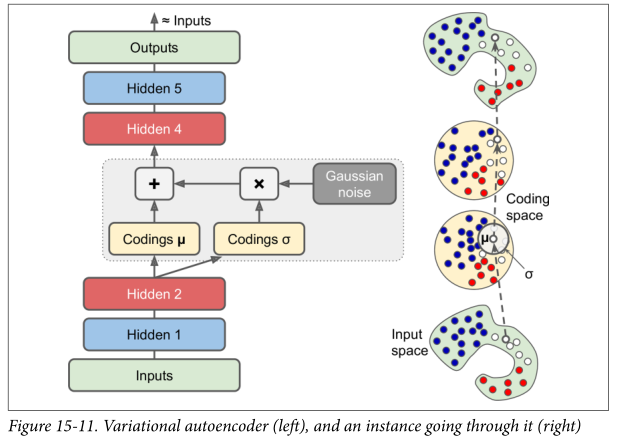

如图所示，尽管输入可能具有非常复杂的分布，但是变分自动编码器倾向于产生看起来好像是从简单的高斯分布中采样的编码：

* 在训练期间，成本函数（下面讨论）推动编码在编码空间（也称为潜在空间）内逐渐迁移，以占据看起来像高斯点云的粗略（超）球形区域。

* 一个重要的结果是，在训练变分自动编码器之后，你可以非常轻松地生成一个新实例：
   * 只需从高斯分布中对随机编码进行采样，对其进行解码，
   * 然后再进行操作！



In [95]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

那么让我们来看看成本函数。 它由两部分组成：

* 第一部分是通常的重建损失，它推动自动编码器重现其输入（我们可以使用交叉熵，如前所述）。

* 第二部分是**潜在的损失-latent loss**，它推动自动编码器具有看起来好像是从简单的高斯分布中采样的编码，为此我们使用目标分布（高斯分布）和编码的实际分布之间的KL偏差。

从数学角度看比以前复杂得多，特别是因为高斯噪声限制了可以传输到编码层的信息量（从而推动自动编码器学习有用的特征）。

幸运的是，方程简化了下面的潜在损失代码：

In [96]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [97]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

一种常见的变体是训练编码器输出$γ= log(σ^2)$而不是 $σ$。只要我们需要 $σ$，我们都可以计算 $σ=exp(\frac{γ}{2})$。这使得编码器更容易捕获不同尺度的sigma，因此它有助于加速收敛。 潜在的损失最终变得更简单了：
```python
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
```



In [98]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

09% Train total loss: 33956.375 	Reconstruction loss: 24482.105 	Latent loss: 9474.271
1 Train total loss: 30793.75 	Reconstruction loss: 25403.44 	Latent loss: 5390.31
29% Train total loss: 32093.91 	Reconstruction loss: 23220.719 	Latent loss: 8873.19
3 Train total loss: 34110.367 	Reconstruction loss: 25802.898 	Latent loss: 8307.468
4 Train total loss: 27073.686 	Reconstruction loss: 21987.027 	Latent loss: 5086.6577
5 Train total loss: 23463.988 	Reconstruction loss: 20248.355 	Latent loss: 3215.6328
69% Train total loss: 18757.344 	Reconstruction loss: 15888.006 	Latent loss: 2869.3381
7 Train total loss: 19263.246 	Reconstruction loss: 16365.022 	Latent loss: 2898.223
8 Train total loss: 16830.525 	Reconstruction loss: 13818.645 	Latent loss: 3011.8813
9 Train total loss: 17147.424 	Reconstruction loss: 14011.476 	Latent loss: 3135.9487
10 Train total loss: 16755.68 	Reconstruction loss: 13615.654 	Latent loss: 3140.0251
11 Train total loss: 16194.092 	Reconstruction loss: 13117

以下代码构建了如图15-11所示的变分自动编码器（左），使用$log(σ^2)$变体：

In [99]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 7.1 Generate digits - 生成数字

现在让我们使用这个变分自动编码器来生成看起来像手写数字的图像。 我们需要做的就是训练模型，然后从高斯分布中抽样随机编码并对其进行解码。

In [100]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

09% Train total loss: 17792.723 	Reconstruction loss: 14123.083 	Latent loss: 3669.6404
1 Train total loss: 17332.346 	Reconstruction loss: 13560.1 	Latent loss: 3772.2463
29% Train total loss: 16350.873 	Reconstruction loss: 12579.393 	Latent loss: 3771.4807
3 Train total loss: 16581.447 	Reconstruction loss: 12810.661 	Latent loss: 3770.7866
4 Train total loss: 16224.016 	Reconstruction loss: 12450.172 	Latent loss: 3773.8433
5 Train total loss: 15628.262 	Reconstruction loss: 11819.755 	Latent loss: 3808.5068
6 Train total loss: 16081.008 	Reconstruction loss: 12179.777 	Latent loss: 3901.231
79% Train total loss: 15772.934 	Reconstruction loss: 12021.412 	Latent loss: 3751.5212
89% Train total loss: 16276.585 	Reconstruction loss: 12404.786 	Latent loss: 3871.7988
9 Train total loss: 15589.723 	Reconstruction loss: 11740.717 	Latent loss: 3849.0063
10 Train total loss: 15931.363 	Reconstruction loss: 12031.385 	Latent loss: 3899.9783
11% Train total loss: 16112.865 	Reconstruction 

现在我们可以看到自动编码器产生的“手写”数字是什么样的（见图15-12）：

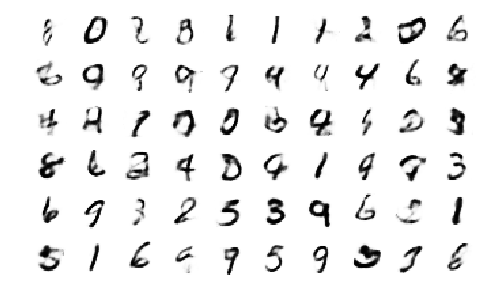

In [101]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

这些数字中的大多数看起来非常有说服力，而有些数字则相当“富有创意”。但是对自动编码器不要太苛刻——它只在不到一个小时前才开始学习。 给它一点训练时间，这些数字看起来会越来越好。

Saving figure generated_digits_plot


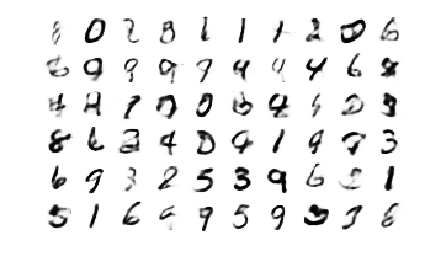

In [102]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
save_fig("generated_digits_plot")
plt.show()

请注意，在第二个变体中，潜在损失的计算方式不同：

In [103]:
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

# 8. Other Autoencoders - 其他自动编码器

监督学习在图像识别，语音识别，文本翻译等方面取得的惊人成功有点掩盖了无监督学习，但它实际上正在蓬勃发展。

自动编码器和其他无监督学习算法的新架构是定期发明的，因此我们无法在本书中全部介绍它们。 以下是你可能想要查看的更多类型的自动编码器的简要概述（绝不是详尽无遗）：


* 压缩自动编码器（CAE）

自动编码器在训练期间受到约束，因此关于输入的编码的导数很小。 换句话说，两个相似的输入必须具有相似的编码。

* 堆叠卷积自动编码器

自动编码器，学习通过重建通过卷积层处理的图像来提取视觉特征。


* 生成随机网络（GSN）10
消除自动编码器的一般化，增加了生成数据的能力。



* Winner-take-all（WTA）自动编码器

在训练期间，在计算编码层中所有神经元的激活之后，仅保留训练批次上的每个神经元的顶部 $k$ 激活，并且其余的被设置为零。 当然，这导致稀疏编码。此外， 类似的WTA方法可用于产生稀疏卷积自动编码器。

* 对抗性自动编码器

训练一个网络以再现其输入，同时训练另一个网络以找到第一网络无法正确重建的输入。这推动了第一个自动编码器学习强大的编码。

# 9. Additional material

## 9.1 Encode & Decode - 编码和解码

Encode:

In [104]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Decode:

In [105]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


让我们绘制重建图：

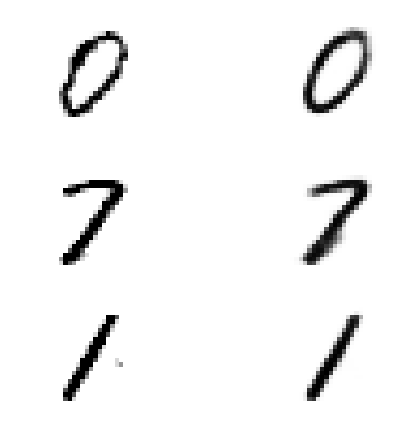

In [106]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## 9.2 Interpolate digits -  插值数字

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


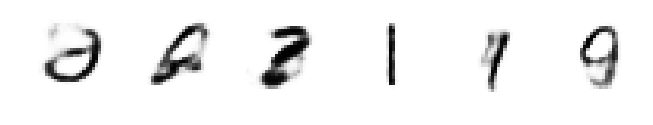

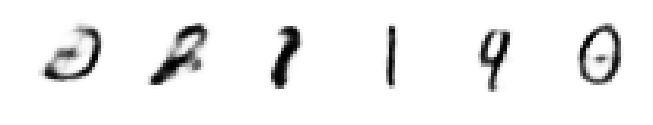

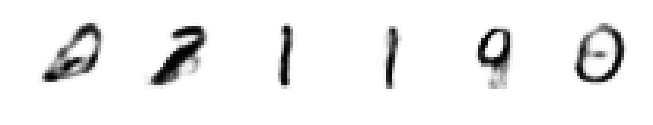

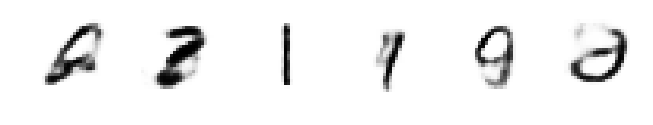

In [107]:
import numpy as np

n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

# Exercise solutions

**1 to 7**

请移步我的简书[Chapter -15 Exercise(1-7)](https://www.jianshu.com/p/4f7e49a47426)

Coming soon...